<a href="https://colab.research.google.com/github/Aithu-Snehith/End-to-End-Learning-of-Communications-Systems-Without-a-Channel-Model/blob/master/4_pam_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import *
from sklearn import preprocessing
import tensorflow.keras.backend as K
from sklearn.metrics import mean_squared_error

In [0]:
msg_total = 4
channel = 4
epochs = 5000
Pert_variance = 1e-4
batch_size = 1024

In [0]:
def perturbation(x):
    w = K.random_normal(shape = (channel,2),
    mean=0.0,stddev=Pert_variance**0.5,dtype=None,seed=None)
    xp = ((1-Pert_variance)**0.5)*x + w
    return xp

def loss_tx(y_true, y_pred):
    return -y_true*y_pred

def get_policy(inp):
    xp = inp[0]
    x = inp[1]
#     w = xp - ((1-Pert_variance)**0.5)*x
    w = xp - x
    policy = -K.sum(w*w)
    return policy

In [4]:
tx_inp = Input((1,))
embbedings_layer = Dense(msg_total, activation = 'relu')(tx_inp)
layer_dense = Dense(2*channel, activation = 'relu')(embbedings_layer)
to_complex = Reshape((channel,2))(layer_dense)
x = Lambda(lambda x: keras.backend.l2_normalize(x))(to_complex)
xp = Lambda(perturbation)(to_complex)
policy = Lambda(get_policy)([xp,x])

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model_policy = keras.models.Model(inputs=tx_inp, outputs=policy)
model_tx = keras.models.Model(inputs=tx_inp, outputs=xp)
model_x = keras.models.Model(inputs=tx_inp, outputs=x)

model_policy.compile(loss=loss_tx, optimizer=tf.keras.optimizers.SGD(lr = 1e-5))
print(model_policy.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 4)            8           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            40          dense[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (None, 4, 2)         0           dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [6]:
rx_inp = Input((channel,2))
to_flat = Reshape((2*channel,))(rx_inp)
fc = Dense(8*2*channel, activation = 'relu')(to_flat)
softmax = Dense(msg_total, activation = 'softmax')(fc)

model_rx = keras.models.Model(inputs=rx_inp, outputs=softmax)

model_rx.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam())
print(model_rx.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 2)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 836
Trainable params: 836
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
loss_tx = []
loss_rx = []
for epoch in range(epochs):
    raw_input = np.random.randint(0,msg_total,(batch_size))
    label = np.zeros((batch_size, msg_total))
    label[np.arange(batch_size), raw_input] = 1
    tx_input = raw_input/float(msg_total)
    xp = model_tx.predict(tx_input)
    y = xp + np.random.normal(0,0.001,(batch_size, channel,2))
    pred = model_rx.predict(y)
    loss = np.sum(np.square(label - pred), axis = 1)
    #   print('epoch: ', epoch)
    history_tx = model_policy.fit(tx_input, loss, batch_size=batch_size, epochs=1, verbose=0)    
    loss_tx.append(history_tx.history['loss'][0])
    
    raw_input = np.random.randint(0,msg_total,(batch_size))
    label = np.zeros((batch_size, msg_total))
    label[np.arange(batch_size), raw_input] = 1
    tx_input = raw_input/float(msg_total)
    x = model_x.predict(tx_input)
    y = x + np.random.normal(0,0.001,(batch_size, channel,2))
    history_rx = model_rx.fit(y, label, batch_size=batch_size, epochs=1, verbose=0)
    loss_rx.append(history_rx.history['loss'][0])
    
    if(epoch % 100 == 0):
        print('epoch: ', epoch, 'tx_loss', history_tx.history['loss'][0], 'rx_loss', history_rx.history['loss'][0])

Instructions for updating:
Use tf.cast instead.
epoch:  0 tx_loss 49.00419616699219 rx_loss 1.3652182817459106
epoch:  100 tx_loss 1.9868937730789185 rx_loss 1.1966124773025513
epoch:  200 tx_loss 0.8701435327529907 rx_loss 0.981144905090332
epoch:  300 tx_loss 0.8815153241157532 rx_loss 0.8404021263122559
epoch:  400 tx_loss 0.6692469120025635 rx_loss 0.7669694423675537
epoch:  500 tx_loss 0.2357269674539566 rx_loss 0.6614512205123901
epoch:  600 tx_loss 0.6070676445960999 rx_loss 0.5855876207351685
epoch:  700 tx_loss 0.7677830457687378 rx_loss 0.5279688835144043
epoch:  800 tx_loss 0.4876845180988312 rx_loss 0.4745243191719055
epoch:  900 tx_loss 0.29224133491516113 rx_loss 0.4361570179462433
epoch:  1000 tx_loss 0.7527302503585815 rx_loss 0.4069991409778595
epoch:  1100 tx_loss 0.8227713108062744 rx_loss 0.4055545926094055
epoch:  1200 tx_loss 0.6096112132072449 rx_loss 0.3938697576522827
epoch:  1300 tx_loss 0.5196916460990906 rx_loss 0.37291690707206726
epoch:  1400 tx_loss 1.316

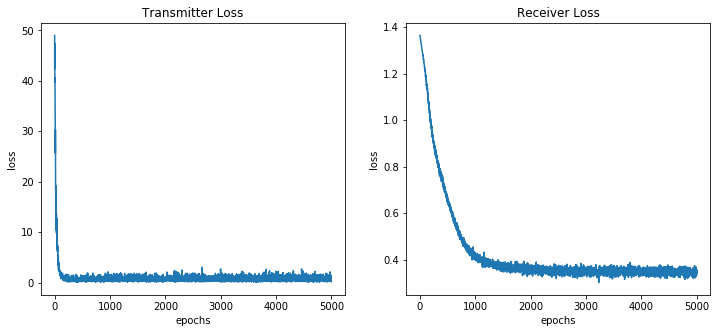

In [8]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(loss_tx)
plt.title('Transmitter Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot(loss_rx)
plt.title('Receiver Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [17]:
#testing
batch_size = 100
raw_input = np.random.randint(0,msg_total,(batch_size))
print(raw_input)
label = np.zeros((batch_size, msg_total))
label[np.arange(batch_size), raw_input] = 1
tx_input = raw_input/float(msg_total)
xp = model_x.predict(tx_input)
y = xp + np.random.normal(0,0.001,(batch_size, channel,2))
pred = model_rx.predict(y)
pred_int = np.argmax(pred, axis = 1)
print(pred_int)

from sklearn.metrics import accuracy_score

print('accuracy:',accuracy_score(raw_input, pred_int))

[0 2 1 1 0 2 3 3 0 2 1 3 2 0 3 0 3 0 0 3 0 3 0 1 0 0 0 0 2 0 0 2 0 0 3 1 2
 2 2 1 0 0 1 1 2 1 3 1 1 0 1 3 3 2 3 0 0 2 1 2 1 0 0 1 3 3 1 0 2 0 3 1 3 0
 0 2 1 3 0 0 0 2 3 1 2 1 2 0 1 1 1 0 1 3 1 0 3 0 2 0]
[0 1 1 1 0 1 3 3 0 1 1 3 1 0 3 0 3 0 0 3 0 3 0 1 0 0 0 0 1 0 0 1 0 0 3 1 1
 1 1 1 0 0 1 1 1 1 3 1 1 0 1 3 3 1 3 0 0 1 1 1 1 0 0 1 3 3 1 0 1 0 3 1 3 0
 0 1 1 3 0 0 0 1 3 1 1 1 1 0 1 1 1 0 1 3 1 0 3 0 1 0]
accuracy: 0.81
